# Practical demo of MD polymer structure building from scratch

In [1]:
# Supressing annoying warnings (!must be done first!)
import warnings
warnings.catch_warnings(record=True)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import logging
from polymerist.genutils.logutils.IOHandlers import LOG_FORMATTER

logging.basicConfig(
    level=logging.INFO,
    format =LOG_FORMATTER._fmt,
    datefmt=LOG_FORMATTER.datefmt,
    force=True
)
LOGGER = logging.getLogger(__name__)

from rdkit import Chem
from rdkit.Chem.AllChem import EmbedMolecule

from polymerist.rdutils import rdkdraw # configure molecule drawing
rdkdraw.set_rdkdraw_size(400, 3/2)
rdkdraw.disable_substruct_highlights()

# 1) Building monomer templates and PDB files from basic SMILES

## Define SMILES for single monomer unit

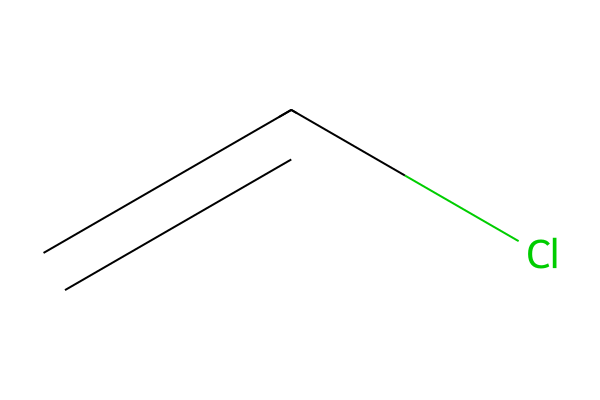

In [2]:
## PVC
molname = 'polyvinylchloride'
smiles = 'C=C-Cl'
bond_atom_map_nums = (1, 2) # for bond cleavage assignment
isotope_map = {
    3 : 0,
    4 : 0
}

## PE
# molname = 'polyethylene'
# smiles = 'C=C'
# bond_atom_map_nums = (1, 2) # for bond cleavage assignment
# isotope_map = {
#     3 : 0,
#     4 : 0
# }

## PAAm
# molname = 'polyacrylamide'
# smiles = 'C=CC(=O)N'
# bond_atom_map_nums = (1, 2)
# isotope_map = {
#     7 : 0,
#     8 : 0
# }

## PS
# molname = 'polystyrene'
# smiles = 'c1ccccc1C=C'
# smiles = 'c1ccc[13cH]c1C=C'
# bond_atom_map_nums = (7, 8) # for bond cleavage assignment
# isotope_map = {
#     14 : 0,
#     16 : 0
# }

## Chitosan
# molname = 'polyglucosamine'
# smiles = 'N[C@H]1C(O)OC(CO)[C@@H](O)[C@@H]1O'

orig_smiles_mol = Chem.MolFromSmiles(smiles, sanitize=False)
display(orig_smiles_mol)

## Expand SMILES to include full chemical info 
Namely, this includes explicit Hs, Kekulized aromatic rings, and atom map numbers

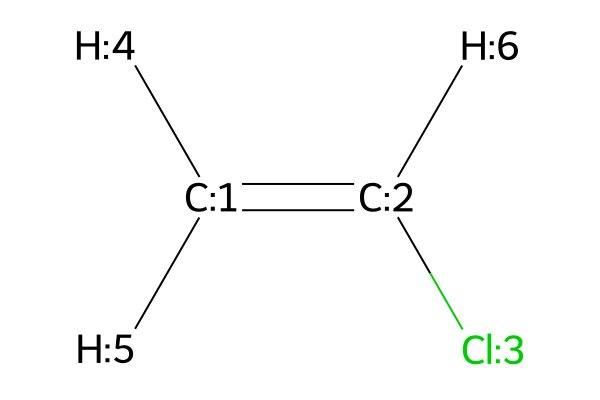

[C:1](=[C:2](-[Cl:3])-[H:6])(-[H:4])-[H:5]


In [3]:
from polymerist.monomers.substruct import specification
from pathlib import Path

outdir = Path(f'demos/{molname}')
outdir.mkdir(exist_ok=True, parents=True)

new_smiles = specification.expanded_SMILES(smiles)
FULL_SMILES_MOL = Chem.MolFromSmiles(new_smiles, sanitize=False)
display(FULL_SMILES_MOL)
print(new_smiles)

## Assigning linkers for inter-monomer bonds

In [4]:
from enum import Enum, auto

class PortMethod(Enum):
    '''For specifying how ports should be added to a complete RDMol'''
    MAP_NUMBERS   = auto()
    BOND_CLEAVAGE = auto()
    REACTION      = auto() # not included here : provide an MDL rxn template

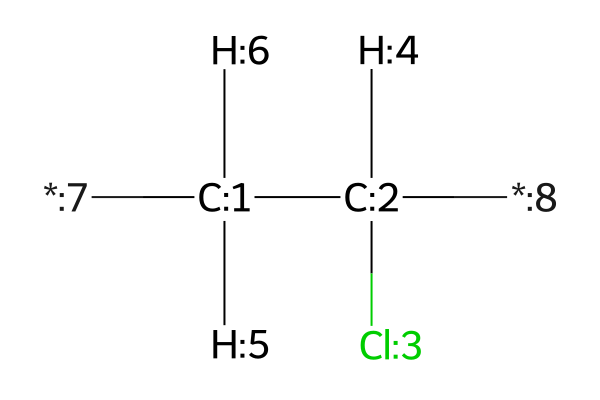

In [5]:
from polymerist.rdutils.labeling import molwise
from polymerist.rdutils.amalgamation import portlib, bonding


assign_port_by = PortMethod.BOND_CLEAVAGE
if portlib.get_num_ports(FULL_SMILES_MOL) == 0: # check for existence of ports to ensure idempotency
    if assign_port_by == PortMethod.MAP_NUMBERS:
        map_nums = isotope_map.keys()
        for (atom_id, map_num) in zip(molwise.atom_ids_by_map_nums(FULL_SMILES_MOL, *map_nums), map_nums):
            linker_atom = FULL_SMILES_MOL.GetAtomWithIdx(atom_id)
            linker_atom.SetIsotope(isotope_map[map_num])
            linker_atom.SetAtomicNum(0)

    elif assign_port_by == PortMethod.BOND_CLEAVAGE:
        rwmol = Chem.RWMol(FULL_SMILES_MOL)
        bond_atom_ids = molwise.atom_ids_by_map_nums(rwmol, *bond_atom_map_nums)
        FULL_SMILES_MOL = bonding.decrease_bond_order(rwmol, *bond_atom_ids)
        molwise.assign_ordered_atom_map_nums(FULL_SMILES_MOL, in_place=True)
        Chem.SanitizeMol(FULL_SMILES_MOL, sanitizeOps=specification.SANITIZE_AS_KEKULE) 

    elif assign_port_by == PortMethod.REACTION:
        raise NotImplemented
    else:
        raise TypeError(f'Must provide a valid port assignment method (cannot be of type {type(assign_port_by)})')

display(FULL_SMILES_MOL)

## Enumerating "cap" groups from linkers and generating spec-compliant SMARTS

In [6]:
from copy import deepcopy
from polymerist.genutils.iteration import subsets


smarts = {}
sat_ids = subsets(portlib.get_linker_ids(FULL_SMILES_MOL), exclude_full=True)
for i, linkers_to_saturate in enumerate(sat_ids):
    new_mono = deepcopy(FULL_SMILES_MOL)
    for linker_id in linkers_to_saturate:
        linker_atom = new_mono.GetAtomWithIdx(linker_id)
        linker_atom.SetAtomicNum(1)
    new_mono = molwise.assign_ordered_atom_map_nums(new_mono, in_place=False)
    Chem.SanitizeMol(new_mono, sanitizeOps=specification.SANITIZE_AS_KEKULE)

    key = molname if not i else f'{molname}_TERM{i}'
    smarts[key] = [specification.compliant_mol_SMARTS(Chem.MolToSmiles(new_mono)).replace('#0', '*')] # for some reason, MolToSmarts doesn't reflect hydrogen addition

2023-11-13 22:23:20.172 [WARNING :   specification:line 126 ] - Cleaned 8 SMARTS atom query aberrations introduced by RDKit
2023-11-13 22:23:20.180 [WARNING :   specification:line 126 ] - Cleaned 8 SMARTS atom query aberrations introduced by RDKit
2023-11-13 22:23:20.187 [WARNING :   specification:line 126 ] - Cleaned 8 SMARTS atom query aberrations introduced by RDKit


## Specify orientation of terminal monomers and create monomer representation object

polyvinylchloride


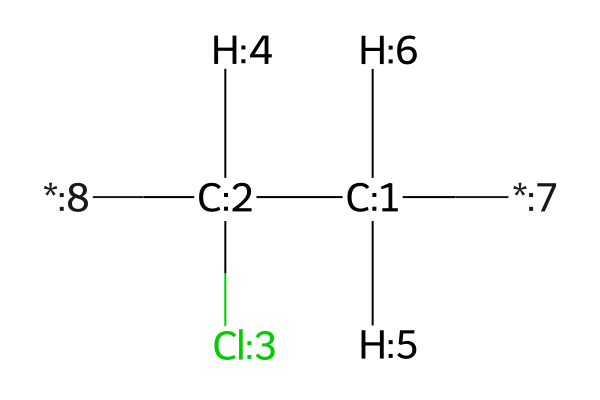

polyvinylchloride_TERM1


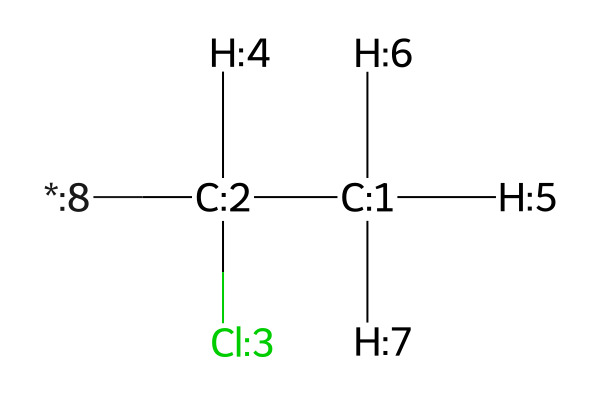

polyvinylchloride_TERM2


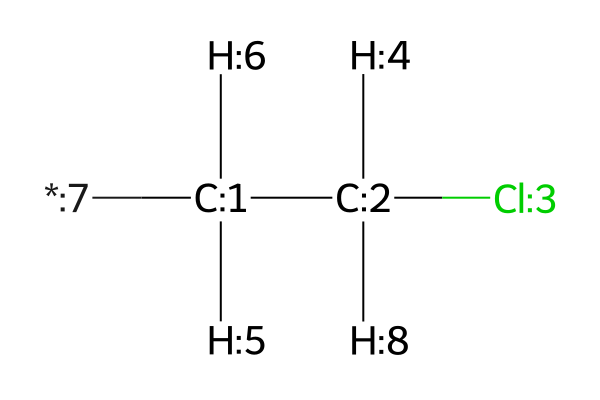

In [7]:
from polymerist.monomers import MonomerGroup
from polymerist.genutils.fileutils.pathutils import assemble_path


grp = MonomerGroup(
    monomers=smarts,
    term_orient={
        f'{molname}_TERM1' : 'head',
        f'{molname}_TERM2' : 'tail',
    }    
)

for (resname, rdmol) in grp.iter_rdmols():
    print(resname)
    display(rdmol)

mono_path = assemble_path(outdir, molname, extension='json')
grp.to_file(mono_path) # cache monomer SMARTS for future use

## Grow chain and generate PDB (only linear polymers currently supported!)

In [8]:
from polymerist.polymers import building

DOP = 4

chain = building.build_linear_polymer(grp, DOP=DOP)
pdb_path = assemble_path(outdir, molname, extension='pdb')
building.mbmol_to_openmm_pdb(pdb_path, chain)
chain.visualize(backend='nglview')

2023-11-13 22:23:20.459 [INFO    :        building:line 78  ] - Using pre-defined terminal group orientation {'polyvinylchloride_TERM1': 'head', 'polyvinylchloride_TERM2': 'tail'}
2023-11-13 22:23:20.461 [INFO    :        building:line 89  ] - Registering middle monomer polyvinylchloride (block identifier "A")
2023-11-13 22:23:20.512 [INFO    :        building:line 100 ] - Registering terminal monomer polyvinylchloride_TERM1 (orientation "head")
2023-11-13 22:23:20.527 [INFO    :        building:line 100 ] - Registering terminal monomer polyvinylchloride_TERM2 (orientation "tail")


[4, 7]


2023-11-13 22:23:20.542 [INFO    :        building:line 107 ] - Assembling linear polymer chain with 4 monomers (26 atoms)
2023-11-13 22:23:20.553 [INFO    :        building:line 111 ] - Successfully assembled linear polymer chain with 4 monomers (26 atoms)


NGLWidget()

# 2) Load and parameterize with OpenFF

## Load chemical info into PDB, partitioning into distinct residues

In [10]:
from openff.toolkit import Topology, Molecule
from polymerist.openfftools import topology
from polymerist.residues.partition import partition


pdb_path=Path(f'pdb_test_cleaned/pdbs/simple_polymers/{molname}.pdb') # using pre-made PDB stand-in for now, as mbuild-generated structures are not connecting middle monomers properly
offtop = Topology.from_pdb(pdb_path, _custom_substructures=grp.monomers)
was_partitioned = partition(offtop)
assert(was_partitioned)
offmol = topology.get_largest_offmol(offtop)

display(offmol)

top_path = assemble_path(outdir, molname, extension='sdf')
topology.topology_to_sdf(top_path, offtop) # preserve fully-specified system in SDF format

NGLWidget()

2023-11-13 22:23:28.052 [INFO    :        topology:line 89  ] - Successfully serialized SDF Topology to demos/polyvinylchloride/polyvinylchloride.sdf


## Assign atomic partial charges

In [21]:
from polymerist.openfftools import pcharge

charger = pcharge.MolCharger.subclass_registry['Espaloma-AM1-BCC']()
cmol = charger.charge_molecule(offmol)

cmol_path = assemble_path(outdir, molname, postfix='charged', extension='sdf')
ctop = cmol.to_topology()
topology.topology_to_sdf(cmol_path, ctop)

2023-11-13 22:32:05.667 [INFO    :         pcharge:line 34  ] - Assigning partial charges via the "Espaloma-AM1-BCC" method
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/espaloma_charge/openff_wrapper.py:112: IncorrectNumConformersWarning: Molecule 'Molecule with name '' and SMILES '[H][C@@](C([H])([H])[H])(C([H])([H])[C@]([H])(C([H])([H])[C@]([H])(C([H])([H])[C@]([H])(C([H])([H])[C@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@]([H])(C([H])([H])[C@]([H])(C([H])([H])C([H])([H])Cl)Cl)Cl)Cl)Cl)Cl)Cl)Cl)Cl)Cl'' has 1 conformers, but charge method 'espaloma-am1bcc' expects exactly 0.
  self._check_n_conformers(
2023-11-13 22:32:05.723 [INFO    :         pcharge:line 37  ] - Successfully assigned "Espaloma-AM1-BCC" charges
2023-11-13 22:32:05.749 [INFO    :        topology:line 89  ] - Successfully serialized SDF Topology to demos/polyvinylchloride/polyvinylchloride_charged.sdf


## Defining periodic box and packing with solvent

In [35]:
import numpy as np
from openmm.unit import gram, centimeter, nanometer
from polymerist.openfftools.solvation import boxvectors, solvents, packing
from polymerist.openfftools.solvation.packing import pack_topology_with_solvent


rho = 0.997 * gram / centimeter**3
box_dims = np.array([4.0, 4.0, 4.0]) * nanometer
solvent = solvents.water_TIP3P

box_vecs = boxvectors.box_vectors_flexible(box_dims)
solv_top = pack_topology_with_solvent(ctop, solvent=solvent, box_vecs=box_vecs, density=rho)
solv_path = assemble_path(outdir, molname, postfix=f'solv_{solvent.name}', extension='sdf')
topology.topology_to_sdf(solv_path, solv_top)

2023-11-13 22:41:42.640 [INFO    :         packing:line 35  ] - Solvating 63.99999999999998 nm**3 Topology with 2134 water_TIP3P molecules to density of 0.997 g/(cm**3)


2023-11-13 22:41:45.467 [INFO    :         packing:line 44  ] - Packmol packing converged
2023-11-13 22:41:45.469 [INFO    :         packing:line 47  ] - Set solvated Topology box vectors to [[4.0 0.0 0.0] [0.0 4.0 0.0] [0.0 0.0 4.0]] nanometer
2023-11-13 22:41:48.054 [INFO    :        topology:line 89  ] - Successfully serialized SDF Topology to demos/polyvinylchloride/polyvinylchloride_solv_water_TIP3P.sdf


## Generate OpenMM files and run simulations

In [37]:
from polymerist.openmmtools.parameters import SimulationParameters
from polymerist.openfftools.omminter import openff_topology_to_openmm
from polymerist.openmmtools.execution import run_simulation_schedule

ff_name = 'openff-2.0.0'
sim_params_path = Path('sample_sim_params.json')

sim_params = SimulationParameters.from_file(sim_params_path)
print(sim_params.thermo_params)
print(sim_params.integ_params)
print(sim_params.reporter_params)
schedule = {
    'demo' : sim_params
}

ommtop, ommsys, ommpos = openff_topology_to_openmm(solv_top, forcefield=ff_name, box_vecs=box_vecs)

ommdir = outdir / 'openmm'
ommdir.mkdir(exist_ok=True)
history = run_simulation_schedule(ommdir, schedule, ommtop, ommsys, ommpos, return_history=True)

ThermoParameters(ensemble='NVT', temperature=Quantity(value=300, unit=kelvin), pressure=Quantity(value=1, unit=atmosphere), friction_coeff=Quantity(value=1, unit=/picosecond), barostat_freq=100)
IntegratorParameters(time_step=Quantity(value=2, unit=femtosecond), total_time=Quantity(value=100, unit=picosecond), num_samples=50)
ReporterParameters(report_checkpoint=True, report_state=True, report_trajectory=True, report_state_data=True, traj_ext='dcd', num_steps=50000, state_data={'step': True, 'time': True, 'potentialEnergy': True, 'kineticEnergy': True, 'totalEnergy': True, 'temperature': True, 'volume': True, 'density': True, 'speed': True, 'progress': False, 'remainingTime': False, 'elapsedTime': False}, reporter_paths=None)


2023-11-13 22:44:44.791 [INFO    :      parameters:line 2993] - Attempting to up-convert Electrostatics section from 0.3 to 0.4
2023-11-13 22:44:44.792 [INFO    :      parameters:line 3003] - Successfully up-converted Electrostatics section from 0.3 to 0.4. `method="PME"` is now split into `periodic_potential="Ewald3D-ConductingBoundary"`, `nonperiodic_potential="Coulomb"`, and `exception_potential="Coulomb"`.
2023-11-13 22:44:53.396 [INFO    :       execution:line 38  ] - Initializing simulation 1/1 ("demo")
2023-11-13 22:44:53.399 [INFO    :          thermo:line 83  ] - Created LangevinMiddleIntegrator for NVT (Canonical) ensemble
2023-11-13 22:44:55.093 [INFO    :       reporters:line 127 ] - Prepared DCDReporter which reports to demos/polyvinylchloride/openmm/demo/demo_trajectory.dcd
2023-11-13 22:44:55.094 [INFO    :       reporters:line 127 ] - Prepared CheckpointReporter which reports to demos/polyvinylchloride/openmm/demo/demo_checkpoint.chk
2023-11-13 22:44:55.096 [INFO    :  